In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import matplotlib.cm as cm
from shapely.geometry import Polygon, mapping
import folium

In [2]:
BTVpolice = pd.read_csv('data/BTVpolice.csv')

In [37]:
my_coordinates= (44.485496875547014, -73.20655684935402)
range= 0.0005
left= -73.20655684935402 - range
right = -73.20655684935402 + range
top = 44.485496875547014 + range
bottom = 44.485496875547014 - range

box1_cond = (bottom <= BTVpolice.Latitude) & (BTVpolice.Latitude <= top) & (left <= BTVpolice.Longitude) & (BTVpolice.Longitude <= right)
withinRange = BTVpolice[(bottom <= BTVpolice.Latitude) & (BTVpolice.Latitude <= top) & (left <= BTVpolice.Longitude) & (BTVpolice.Longitude <= right)]
AtHouse = withinRange[withinRange['Street'].str.contains('North St')]
AtHouse.head(5)
AtHouse.size

627

/var/folders/05/b_dps8k90m5d6w0ttvf7hzg40000gn/T/ipykernel_14312/622918854.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = cm.get_cmap('plasma', len(contour_levels))
/var/folders/05/b_dps8k90m5d6w0ttvf7hzg40000gn/T/ipykernel_14312/622918854.py:26: MatplotlibDeprecationWarning: The collections attribute was deprecated in Matplotlib 3.8 and will be removed in 3.10.
  for i, level in enumerate(contours.collections):


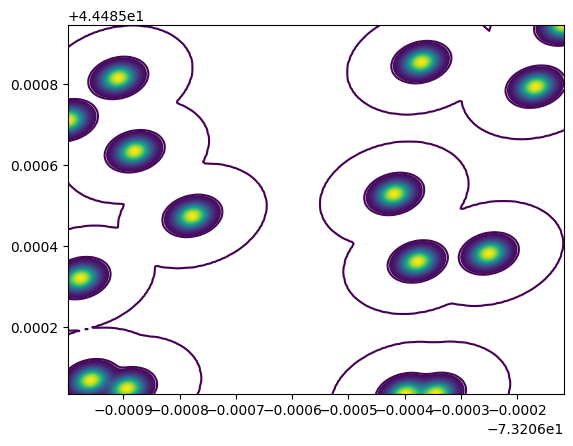

In [41]:


withinRangeP1 = withinRange[withinRange['priority'] == "Priority 1"]

withinRangeP1Filtered = withinRangeP1.dropna(subset=['Latitude', 'Longitude'])

x = withinRangeP1Filtered['Longitude'].values
y = withinRangeP1Filtered['Latitude'].values

xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()
xx, yy = np.mgrid[xmin:xmax:200j, ymin:ymax:200j]

positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = stats.gaussian_kde(values, bw_method=0.055)
density = np.reshape(kernel(positions).T, xx.shape)

contour_levels = np.linspace(density.min() + 0.0001, density.max(), 80)  #change last number to add levels

features = []

colormap = cm.get_cmap('plasma', len(contour_levels))

fig, ax = plt.subplots()
contours = ax.contour(xx, yy, density, levels=contour_levels)

for i, level in enumerate(contours.collections):
    color = colormap(i / len(contour_levels))
    for contour_path in level.get_paths():
        for segment in contour_path.to_polygons():
            poly = Polygon(segment)
            if poly.is_valid:
                feature = {
                    "type": "Feature",
                    "geometry": mapping(poly),
                    "properties": {
                        "level": contour_levels[i],
                        "color": f'rgba({int(color[0]*255)}, {int(color[1]*255)}, {int(color[2]*255)}, 0.4)' 
                    }
                }
                features.append(feature)

geojson_data = {
    "type": "FeatureCollection",
    "features": features
}

burlington_map = folium.Map(location=[44.4759, -73.2121], zoom_start=13)

folium.GeoJson(
    geojson_data,
    style_function=lambda feature: {
        "fillColor": feature["properties"]["color"],
        "color": "black",
        "weight": 0.1,
        "fillOpacity": 0.05 
    }
).add_to(burlington_map)

burlington_map


In [42]:
withinRange['Street'].value_counts().head(5)

Street
N Winooski Ave    50
Riverside Ave     39
N Willard St      26
Hyde St           23
Pearl St          20
Name: count, dtype: int64

In [38]:
AtHouse['call_type_group'].value_counts().head(5)

call_type_group
Motor Vehicle      16
Quality of Life     5
Public Service      4
Property            4
Assist              2
Name: count, dtype: int64

In [40]:
MotorVehicle = AtHouse[AtHouse['call_type_group']=='Motor Vehicle']
MotorVehicle['call_origin'].value_counts().head(5)

call_origin
Phone            7
Officer/Radio    6
Online Report    2
911              1
Name: count, dtype: int64